# CS 614 - Applications of Machine Learning 
## Programming Assignment 1 - Credit Card Fraud

### Load the Libraries
So our first step is to import these various libraries.  Depending on your current setup, you may need to install one or more of these (either via pip install or via your IDE).

In [33]:
import numpy as np
import math
import time
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import torch
import torch.nn as nn

### Download and Import the Data
Now let's load our data.   For this lab we'll use the credit card fraud dataset on Kaggle.  You can find (and download) it here:
https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

This link provides description of the dataset and download links.  There is also code.  **You may not** use any of the code posted there (or elsewhere).

In the provided code, I stored my datasets three directories up from my current working directory.

In [34]:
data = pd.read_csv("datasets/creditcard.csv", header=0,dtype=np.float32)
data = data.to_numpy()  #convert to numpy

#the last column contains our targets
X = data[:,0:data.shape[1]-1]
Y = np.atleast_2d(data[:,-1]).T  #Needed to make our targets an Nx1 matrix

#use sklearn to split randomize and split our data into training and testing.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33)

### Standardize Our Data
Since we'll be doing gradient-based learning, it will likely be advantageous to standardize our data.  Your first task will to be to z-scored our data, such that each feature (column) has approximately zero mean and unit deviation

**Note:** We standardize all of our data with just the mean and standard deviation extracted from the training data

In [35]:
#TODO
#Z-score your training and testing data

# Calculate mean and standard deviation from training data 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

# Z-score standardization: (X - mean) / std deviation
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

### Create Pytorch Tensors from Data
Now that our data is ready, let's convert it to pytorch tensors


In [36]:
#assumes training and testing data is stored as X_train, Y_train, X_test, Y_test after z-scoring
X_train = torch.from_numpy(X_train)
Y_train = torch.from_numpy(Y_train)

X_test = torch.from_numpy(X_test)
Y_test = torch.from_numpy(Y_test)

### Create Architecture
Now for the fun part!
Let's play around with some architectures!
Use Pytorch to create a *sequential* network with the following architecture:

$$Linear \rightarrow Activation \rightarrow Linear \rightarrow Acivation \rightarrow \hat{Y}$$

This is a basic artificial neural network (ANN).

You can play with some of the design/hyperparameter choices, namely:
* Hidden layer size
* Hidden layer activation function
* Output layer activation function

In [37]:
#TODO
#Create an ANN with the specifications above.  We will assume the resulting model's name is model

# Create a sequential ANN with 1 hidden layer of 16 neurons
model = nn.Sequential(
    nn.Linear(30, 16),      # Input layer: 30 features → 16 hidden neurons
    nn.ReLU(),              # Hidden layer activation function
    nn.Linear(16, 1),       # Output layer: 16 → 1 output
    nn.Sigmoid()            # Output activation (required for BCELoss)
)

### Loss Function and Optimizer
Next we need to decide upon a loss function and an optimizer.
Since we're doing binary classification, a *Binary Cross Entropy* loss function makes sense.
Adagrad is a good default optimizer.

In [38]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adagrad(model.parameters())

### Train our Model
Now let's train our model.  For this first assignment, I'll provide the generic training loop.   In subsequent ones, you'll be asked to do so.

In [39]:
#You'll want to add some timing in here!
start_time = time.time()

results = []
model.train()  #put our model into training mode.  With this set, gradients will be computed during forward pass
while True:
    Yhat = model(X_train)  #forward propagate
    
    loss = loss_fn(Yhat.ravel(),Y_train.ravel())  #compute the loss and append to a list
    results.append(loss.item())

    #backpropagate!
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    #stopping conditions
    if (len(results) > 100 and np.abs(results[-1]-results[-2]) < math.pow(10,-10)) or (len(results) >= 1000):
        break;

end_time = time.time()
training_time = end_time - start_time
print(f'Training completed in {training_time:.2f} seconds ({len(results)} epochs)')

Training completed in 5.22 seconds (1000 epochs)


### Observe The Training Process
Let's observe the training process!
Use matplotlib to create a plot of the mean log loss vs epoch number

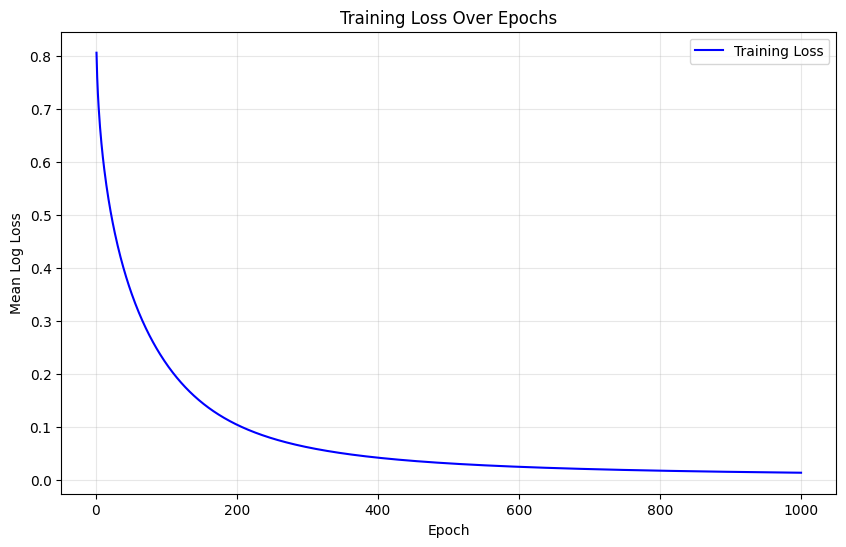

In [ ]:
#TODO
#Create plot of mean log loss vs epoch.  Label each axis and provide a legend

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(results) + 1), results, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('BCE Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Class Priors
We want to know what our class priors are, so we can assess if our classification is at least better than the naive solution (of assigning each observation to the most common class)

In [41]:
#TODO
#Print the class priors

# Calculate class priors from training data
y_train_np = Y_train.detach().numpy()
total_samples = len(y_train_np)
class_0_count = np.sum(y_train_np == 0)
class_1_count = np.sum(y_train_np == 1)

class_0_prior = (class_0_count / total_samples) * 100
class_1_prior = (class_1_count / total_samples) * 100

print("Class Priors (Training Data):")
print(f"  Class 0 (Legitimate): {class_0_prior:.2f}% ({class_0_count} samples)")
print(f"  Class 1 (Fraud):      {class_1_prior:.2f}% ({class_1_count} samples)")
print(f"\nNaive baseline accuracy (i.e always predict majority class): {max(class_0_prior, class_1_prior):.2f}%")

Class Priors (Training Data):
  Class 0 (Legitimate): 99.82% (190477 samples)
  Class 1 (Fraud):      0.18% (343 samples)

Naive baseline accuracy (i.e always predict majority class): 99.82%


### Report Statistics
And finally let's output the accuracy of the training and testing sets.
Again, for this first lab I'll show you the general process.

In [ ]:
model.eval()   #put in eval mode so no gradients are computed
with torch.no_grad():
    #evaluate training set using learned model
    h = model(X_train)
    yhat_train = 1.0*(h.detach().numpy()>0.5)
    y_train_np = Y_train.detach().numpy()
    accuracy = np.mean(yhat_train==y_train_np)
    
    # Calculate precision and recall for fraud class for training data (class 1)
    tp_train = np.sum((yhat_train == 1) & (y_train_np == 1))
    fp_train = np.sum((yhat_train == 1) & (y_train_np == 0))
    fn_train = np.sum((yhat_train == 0) & (y_train_np == 1))
    
    precision_train = tp_train / (tp_train + fp_train) if (tp_train + fp_train) > 0 else 0
    recall_train = tp_train / (tp_train + fn_train) if (tp_train + fn_train) > 0 else 0
    
    print('Training Accuracy: ',accuracy)
    print(f'Training Precision (Fraud): {precision_train:.4f}')
    print(f'Training Recall (Fraud): {recall_train:.4f}')
        
    #evaluate test set using learned model
    h = model(X_test)
    yhat_test = 1.0*(h.detach().numpy()>0.5)
    y_test_np = Y_test.detach().numpy()
    accuracy = np.mean(yhat_test==y_test_np)
    
    # Calculate precision and recall for fraud class for testing data (class 1)
    tp_test = np.sum((yhat_test == 1) & (y_test_np == 1))
    fp_test = np.sum((yhat_test == 1) & (y_test_np == 0))
    fn_test = np.sum((yhat_test == 0) & (y_test_np == 1))
    
    precision_test = tp_test / (tp_test + fp_test) if (tp_test + fp_test) > 0 else 0
    recall_test = tp_test / (tp_test + fn_test) if (tp_test + fn_test) > 0 else 0
    
    print('\nTesting Accuracy: ',accuracy)
    print(f'Testing Precision (Fraud): {precision_test:.4f}')
    print(f'Testing Recall (Fraud): {recall_test:.4f}')

Training Accuracy:  0.9991405513048947
Training Precision (Fraud): 0.8745
Training Recall (Fraud): 0.6093

Testing Accuracy:  0.9991807377616053
Testing Precision (Fraud): 0.8529
Testing Recall (Fraud): 0.5839
